In [5]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline
import random
import check_test
from plot_utils import plot_values

In [6]:
env = gym.make('CliffWalking-v0')

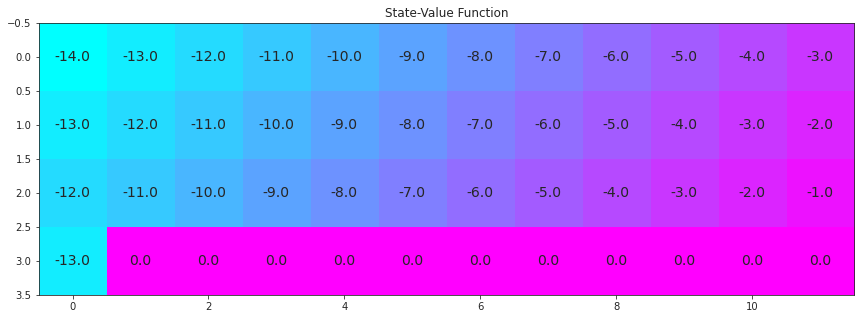

In [7]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

In [10]:
def get_eGreedyAction(Q,state,epsilon):
    choices = [1,2]     # 1 for the random , 2 for the greedy
    probabilities = [epsilon,1-epsilon]
    choice_made = random.choices(choices,probabilities)
    if choice_made == 1:
        return random.choice(random.arrange(env.action_space.n)) 
    else :
        return np.argmax(Q[state])
    
def updateExpSarsa(epsilon,Q,reward,current_state,current_action,next_state,alpha,gamma):
    current_reward = Q[current_state][current_action]
    nA = env.action_space.n  #total actions
    if next_state is not None :
        temp_arr = np.ones(nA) * epsilon / nA  # current policy (for next state S')
        temp_arr[np.argmax(Q[next_state])] = 1 - epsilon + (epsilon / nA) # greedy action
        next_reward = np.dot(Q[next_state], temp_arr) 
    else:
        next_reward = 0
    temp_value = (reward+ (next_reward*gamma))-(current_reward) 
    temp_value*=alpha
    return current_reward + temp_value
    
    
def expected_sarsa(env, num_episodes, alpha, gamma=1.0,plot_every=100):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    # initialize performance monitor
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)
    # loop over episodes
    for ith_episode in range(1, num_episodes+1):
        # monitor progress
        if ith_episode % 100 == 0:
            print("\rEpisode {}/{}".format(ith_episode, num_episodes), end="")
            sys.stdout.flush() 
        score = 0 
        state = env.reset()
        epsilon = 0.005   #set episoln , will decrease with the number of episodes increases
        while True :
            action = get_eGreedyAction(Q,state,epsilon)
            next_state,reward,done,info = env.step(action)
            score+=reward
            if done :
                Q[state][action] = updateExpSarsa(epsilon,Q,reward,state,action,None,alpha,gamma)
                tmp_scores.append(score)
                break
            Q[state][action] = updateExpSarsa(epsilon,Q,reward,state,action,next_state,alpha,gamma)
            state = next_state
        if (ith_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
            
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))    
    return Q 

Episode 5000/5000

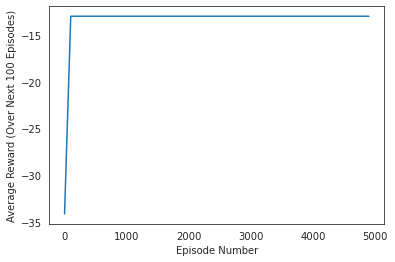

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  0  1  2  1  1  1  1  1  1  1  2]
 [ 0  1  3  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


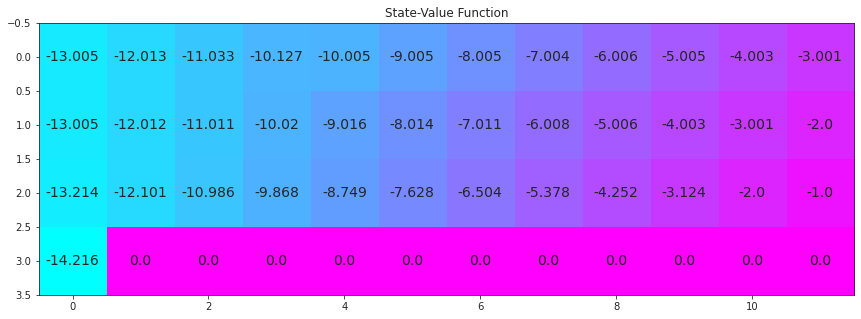

In [11]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 5000, 1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])